In [1]:
import utils
from datagenerators import VARGenerator

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split

In [40]:
def generate_data():
    # Create a config file
    config = utils.parse_config()
    config.update(utils.generate_parameters(config)[0])
    config.c11 = [0.1, 0.5, 0.8, 0.9]
    config.c22 = [0.1, 0.8, 0.9]
    config.c12 = [0, 0.1, 0.3, 0.9]
    config.sigma_eta_diag = [0.3, 0.1, 0.05]
    config.sigma_eta_off_diag = [0.05, 0.02, 0.01]
    mini_configs = utils.generate_parameters(config)

    # Get data from configs
    X, coef_mats, edges, noises, noises_cov = [], [], [], [], []
    for exp_params in mini_configs:
        # Parse config
        experiment_config = utils.deepcopy_lvl1(config)
        experiment_config.update(exp_params)
        experiment_config = utils.get_nested_config(experiment_config)
        noise_cov = np.array([[experiment_config.sigma_eta_diag, experiment_config.sigma_eta_off_diag], [experiment_config.sigma_eta_off_diag, experiment_config.sigma_eta_diag]])

        # Get all of the necessary data
        generator = VARGenerator(experiment_config)
        data, coef_mat, edge = generator.generate()
        noise = generator.get_noise()

        # Save the data
        X.append(data)
        coef_mats.append(coef_mat)
        noises_cov.append(noise_cov)
        edges.append(edge)
        noises.append(noise)

    return np.array(X), np.array(coef_mats), np.array(edges), np.array(noises), np.array(noises_cov)

X, coef_mats, edges, noises, noises_cov = generate_data()
X.shape, coef_mats.shape, edges.shape, noises.shape, noises_cov.shape

((432, 7840, 2), (432, 2, 2), (432, 2, 2), (432, 7840, 2), (432, 2, 2))

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

tvt_split = (0.8, 0.1, 0.1)
N = X.shape[0]
train_size, valid_size = int(tvt_split[0] * N), int(tvt_split[1] * N)
test_size = N - train_size - valid_size

# Create datasets
X_ = torch.from_numpy(X-noises).to(device).to(dtype)
noise_ = torch.from_numpy(noises).to(device).to(dtype)
noises_cov_ = torch.from_numpy(noises_cov).to(device).to(dtype)
dataset = TensorDataset(X_, noise_, noises_cov_)
train_set, valid_set, test_set = random_split(dataset, [train_size, valid_size, test_size])

In [42]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size, hidden1, hidden2):
        super(DenoisingAutoencoder, self).__init__()

        p = input_size
        self.encoder = nn.Sequential(
            nn.Conv1d(p+p*(p+1)//2, hidden1, 1),
            nn.ReLU(),
            nn.Conv1d(hidden1, hidden2, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(hidden2, hidden1, 1),
            nn.ReLU(),
            nn.Conv1d(hidden1, p, 1)
        )

    def forward(self, x, cov_mat):
        # Reshape inputs in the desired shape
        x = x.transpose(1, 0)
        cov_mat = cov_mat[np.tril_indices(cov_mat.shape[0])].flatten()
        cov_mat = cov_mat.repeat(x.shape[-1], 1).transpose(1,0)

        # Perform the forward pass
        x = torch.concat([x, cov_mat], 0)
        x = self.encoder(x)
        x = self.decoder(x)
        return x.transpose(0,1)

In [43]:
input_size = X.shape[-1]
hidden1, hidden2 = 100, 50

model = DenoisingAutoencoder(input_size, hidden1, hidden2).to(device)
loss_mse = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())

In [45]:
epochs = 50

train_losses, valid_losses = [], []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    losses = []
    for i, (x, noise, noise_cov) in enumerate(train_set):
        # Forward pass
        x_noisy = x + noise
        x_est = model(x_noisy, noise_cov)
        loss = loss_mse(x, x_est)

        # Backward pass
        loss.backward()
        optim.step()
        optim.zero_grad()
        losses.append(loss.item())
    train_losses.append(sum(losses) / len(losses))

    model.eval()
    valid_loss = 0
    losses = []
    with torch.no_grad():
        for i, (x, noise, noise_cov) in enumerate(valid_set):
            # Forward pass
            x_noisy = x + noise
            x_est = model(x_noisy, noise_cov)
            loss = loss_mse(x, x_est)

            # Add validation loss
            losses.append(loss.item())
    valid_losses.append(sum(losses) / len(losses))

    print(f"Epoch {epoch}/{epochs} | Train Loss: {train_losses[-1]} | Valid loss: {valid_losses[-1]}")

# Test phase
losses = []
model.eval()
for i, (x, noise, noise_cov) in enumerate(test_set):
    # Forward pass
    with torch.no_grad():
        x_noisy = x + noise
        x_est = model(x_noisy, noise_cov)
        loss = loss_mse(x, x_est)

        # Add validation loss
        losses.append(loss.item())
test_loss = sum(losses) / len(losses)

Epoch 0/50 | Train Loss: 0.11928971918920676 | Valid loss: 0.07915265771538713
Epoch 1/50 | Train Loss: 0.11517188597632491 | Valid loss: 0.0779721264315899
Epoch 2/50 | Train Loss: 0.1138986580532746 | Valid loss: 0.07751691549323327
Epoch 3/50 | Train Loss: 0.10720646485308374 | Valid loss: 0.07746918222238851
Epoch 4/50 | Train Loss: 0.11156479406400004 | Valid loss: 0.07752085126243359
Epoch 5/50 | Train Loss: 0.1065579401842062 | Valid loss: 0.07750280552305454
Epoch 6/50 | Train Loss: 0.10857591453831697 | Valid loss: 0.0774954147203717
Epoch 7/50 | Train Loss: 0.1065932139052429 | Valid loss: 0.07748507444075374
Epoch 8/50 | Train Loss: 0.10721170399068058 | Valid loss: 0.07748606047311495
Epoch 9/50 | Train Loss: 0.10690860649489838 | Valid loss: 0.07746794144081515
Epoch 10/50 | Train Loss: 0.10664642116567795 | Valid loss: 0.07748113828169745
Epoch 11/50 | Train Loss: 0.10687859975665376 | Valid loss: 0.07745283755452134
Epoch 12/50 | Train Loss: 0.10654770574275998 | Valid l

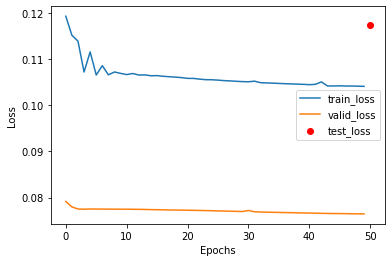

In [46]:
plt.plot(train_losses, label='train_loss')
plt.plot(valid_losses, label='valid_loss')
plt.scatter(len(valid_losses), test_loss, label='test_loss', color='r')
plt.ylabel('Loss')
plt.xlabel('Epochs')

#plt.ylim(0, 1)

plt.legend()
plt.show()

# Usage

In [47]:
# Real data
X_np = np.load('X.npy')
noise_np = np.load('noise.npy')

X_noisy = torch.from_numpy(X_np).to(device).to(dtype)
noise_cov = torch.from_numpy(np.cov(noise_np.T)).to(device).to(dtype)

X_noisy.shape, noise_cov.shape

(torch.Size([7840, 2]), torch.Size([2, 2]))

In [48]:
y = model(X_noisy, noise_cov).detach().cpu().numpy()
y[200:205]

array([[-0.10802288, -0.10201091],
       [-0.07615955, -0.06601729],
       [-0.12711138, -0.12307511],
       [-0.18856591, -0.19841658],
       [-0.13311097, -0.12967958]], dtype=float32)

In [49]:
(X_np - noise_np)[200:205]

array([[-0.29063462, -0.29063463],
       [-0.18083572, -0.18083572],
       [-0.13751319, -0.13751319],
       [-0.2062843 , -0.20628429],
       [-0.29935245, -0.29935245]])

In [50]:
np.save('X_ae.npy', y)